# Gioele Migno 1795826 - HOMEWORK 1
---

Global variables such as strings and numbers are stored in a dictionary called 
GLOBAL_SETTING.

Global (complex) objects instead are not stored in any datastructure but they are named with a uppecase name

# SETUP

In [1]:
GLOBAL_SETTING={
    'RANDOM_SEED': 20220326,
    'DEVICE': 'unknown'
}

In [2]:
GLOBAL_SETTING.update({
    'BATCH_SIZE_TRAIN': 32,
    'BATCH_SIZE_VAL': 32, 
})

In [3]:
GLOBAL_SETTING.update({
    'GENSIM_MODEL_NAME': 'glove.6B.100d.txt'#"word2vec-google-news-300"#'glove.6B.100d.txt'#"glove-wiki-gigaword-100" #"word2vec-google-news-300"#
})

In [4]:
GLOBAL_SETTING.update({
    'WORD_PAD': '<pad>',
    'WORD_UNK': '<unk>',

    'WINDOW_SIZE': 50,
})

In [5]:
GLOBAL_SETTING.update({
    'FLAG_USE_POS_TAGGING': True,
    'FLAG_POS_TAG_USE_ONE_HOT': True,

    'POS_TAGS_SET': None, #'universal', (None = nltk default)

    'UNK_POS_TAG': '<unk>',
})

In [6]:
GLOBAL_SETTING

{'BATCH_SIZE_TRAIN': 32,
 'BATCH_SIZE_VAL': 32,
 'DEVICE': 'unknown',
 'FLAG_POS_TAG_USE_ONE_HOT': True,
 'FLAG_USE_POS_TAGGING': True,
 'GENSIM_MODEL_NAME': 'glove.6B.100d.txt',
 'POS_TAGS_SET': None,
 'RANDOM_SEED': 20220326,
 'UNK_POS_TAG': '<unk>',
 'WINDOW_SIZE': 50,
 'WORD_PAD': '<pad>',
 'WORD_UNK': '<unk>'}

### MOUNT

In [7]:
from google.colab import drive

MOUNT_POINT = '/content/gdrive' 
drive.mount(MOUNT_POINT,  force_remount=True)
MOUNT_POINT += "/My Drive"

Mounted at /content/gdrive


### CHECK GPU ASSIGNED

In [8]:
!nvidia-smi

Tue Apr 19 09:53:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### SETUP FOLDERS AND FILES

In [9]:
import os 

DIR_ROOT = os.path.join(MOUNT_POINT, "5.2/NLP/HOMEWORK_1")

In [10]:
DIR_PWD = os.path.join(DIR_ROOT, "NOTEBOOKS")
DIR_CACHE = os.path.join(DIR_PWD, "CACHE")

DIR_STUDIES = os.path.join(DIR_ROOT, "STUDIES")
DIR_FINAL = os.path.join(DIR_ROOT, "FINAL")
DIR_RESOURCES = os.path.join(DIR_ROOT, "RESOURCES")
DIR_OUTPUT = os.path.join(DIR_ROOT, "OUTPUT")

In [11]:
DIR_DATASET = os.path.join(DIR_RESOURCES, "nlp2022-hw1/data")

FILE_TRAIN = os.path.join(DIR_DATASET, "train.tsv")  
FILE_VAL = os.path.join(DIR_DATASET, "dev.tsv")
#FILE_TEST = os.path.join(DIR_DATASET, "test.jsonl")

#### Cached files

In [12]:
CACHE_FILE_GENSIM_MODEL = os.path.join(DIR_CACHE, GLOBAL_SETTING['GENSIM_MODEL_NAME'] + ".pickle")

In [13]:
CACHE_FILE_TRAIN_SET = os.path.join(DIR_CACHE, 'training_set.pickle')
CACHE_FILE_VAL_SET = os.path.join(DIR_CACHE, 'val_set.pickle')

#### External resources files

In [14]:
if '.txt' in GLOBAL_SETTING['GENSIM_MODEL_NAME']:
  EXTERNAL_EMBEDDING_FILE = os.path.join(DIR_RESOURCES, GLOBAL_SETTING['GENSIM_MODEL_NAME'])
else:
  EXTERNAL_EMBEDDING_FILE = None

EXTERNAL_EMBEDDING_FILE

'/content/gdrive/My Drive/5.2/NLP/HOMEWORK_1/RESOURCES/glove.6B.100d.txt'

# IMPORT

In [15]:
import datetime

In [16]:
from pprint import pprint

In [17]:
import json
import os
import re
import collections
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random

In [18]:
!pip install seqeval > /dev/null
import seqeval.metrics

In [19]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

In [1]:
# used for hyperparameters tuning
!pip install optuna > /dev/null
import optuna
optuna.__version__

'2.10.0'

In [4]:
# used in place of print
!pip install icecream > /dev/null
from icecream import ic

In [22]:
# for cute iteration bars (during training etc.)
from tqdm.auto import tqdm
from typing import *

In [23]:
# torch
import torch
from torch import nn
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD

import torch.nn.functional as F

In [24]:
!pip install nltk > /dev/null
import nltk

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
nltk.download('tagsets')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.


True

In [25]:
nltk.__version__

'3.2.5'

In [ ]:
def load_object(path):
  with open(path, 'rb') as f:
    return pickle.load(f)

def save_object(path, obj):
  with open(path, 'wb') as f:
    pickle.dump(obj, f)

# SET RANDOM SEED

**Note:** RNN models on CUDA cannot be easily made fully deterministic:
https://pytorch.org/docs/stable/notes/randomness.html

In [ ]:
import random
import numpy as np

In [ ]:
def set_random_seed():
  random.seed(GLOBAL_SETTING['RANDOM_SEED'])
  np.random.seed(GLOBAL_SETTING['RANDOM_SEED'])
  torch.manual_seed(GLOBAL_SETTING['RANDOM_SEED'])
  torch.backends.cudnn.deterministic = True

In [ ]:
set_random_seed()

# SELECT DEVICE

In [ ]:
GLOBAL_SETTING['DEVICE'] = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE = GLOBAL_SETTING['DEVICE']

# DATASET

## DATASET ANALYSIS

In [ ]:
def get_data(dataset_path):
  data = {
          #'ids': [], 
          'sentences': {}
          }

  last_id = None
  with open(dataset_path, 'r') as f:
    for line in f:
      splitted = line.strip().split('\t')
      
      if len(splitted) == 3: #start new sentence
        id = splitted[2]
        #data['ids'].append(id)
        last_id = id
        data['sentences'][last_id] = []

      if len(splitted) == 2: 
        data['sentences'][last_id].append((splitted[0], splitted[1]))
        
      if len(splitted) == 1:  #end sentence
        last_id = None

  return data

In [ ]:
_train_data = get_data(FILE_TRAIN)

In [ ]:
_train_data['sentences']['0']

[('it', 'O'),
 ('lies', 'O'),
 ('approximately', 'O'),
 ('north', 'O'),
 ('east', 'O'),
 ('of', 'O'),
 ('bolesławiec', 'B-LOC'),
 (',', 'O'),
 ('and', 'O'),
 ('west', 'O'),
 ('of', 'O'),
 ('the', 'O'),
 ('regional', 'O'),
 ('capital', 'O'),
 ('wrocław', 'B-LOC'),
 ('.', 'O')]

Get some stats about sentences legths

In [ ]:
num_sentences = len(_train_data['sentences'])

lengths_sentences = [len(_train_data['sentences'][key]) for key in _train_data['sentences']]
min_length_sentence = min(lengths_sentences)
max_length_sentence = max(lengths_sentences)
avg_length_sentence = sum(lengths_sentences)/len(lengths_sentences)

ic(num_sentences)
ic(min_length_sentence)
ic(max_length_sentence)
ic(avg_length_sentence);

ic| num_sentences: 14535
ic| min_length_sentence: 1
ic| max_length_sentence: 41
ic| avg_length_sentence: 16.515858273133816


Check smallest sentence

In [ ]:
idx_smallest_sentences = lengths_sentences.index(min_length_sentence)
smallest_sentence = _train_data['sentences'][str(idx_smallest_sentences)]

ic(idx_smallest_sentences)
ic(smallest_sentence);

ic| idx_smallest_sentences: 5368
ic| smallest_sentence: [('4', 'O')]


Tags occurences

In [ ]:
tags_counter = Counter()
for key in _train_data['sentences']:
  for sample in _train_data['sentences'][key]:
    x = sample[0]
    y = sample[1]

    tags_counter[y] += 1

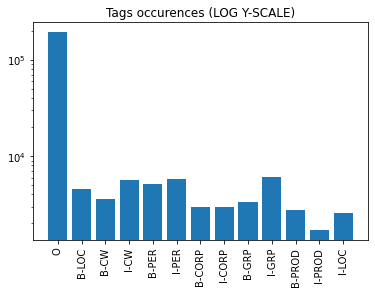

In [ ]:
values = [tags_counter[tag] for tag in tags_counter]

plt.bar(tags_counter.keys(), values)
plt.yscale('log')
plt.xticks(rotation='90')
plt.title("Tags occurences (LOG Y-SCALE)")
plt.show()

In [ ]:
LABELS_COUNTER = {tag: tags_counter[tag] for tag in tags_counter}
ic(LABELS_COUNTER);

ic| LABELS_COUNTER: {'B-CORP': 2975,
                     'B-CW': 3551,
                     'B-GRP': 3375,
                     'B-LOC': 4556,
                     'B-PER': 5090,
                     'B-PROD': 2770,
                     'I-CORP': 2987,
                     'I-CW': 5716,
                     'I-GRP': 6084,
                     'I-LOC': 2598,
                     'I-PER': 5805,
                     'I-PROD': 1710,
                     'O': 192841}


Pos tag stats

In [ ]:
pos_tags_counter = Counter()

for key in _train_data['sentences'].keys():
  sentence_tuple = _train_data['sentences'][key]
  sentence = []
  for word_tuple in sentence_tuple:
    word = word_tuple[0]
    sentence.append(word)
  
  pos_nltk = nltk.tag.pos_tag(sentence)
  #ic(sentence)

  for tag in pos_nltk:
    pos_tags_counter[tag[1]] += 1 
    #ic(tag[1])
  #break

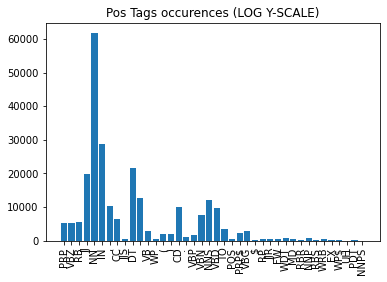

In [ ]:
values = [pos_tags_counter[tag] for tag in pos_tags_counter]

plt.bar(pos_tags_counter.keys(), values)
#plt.yscale('log')
plt.xticks(rotation='90')
plt.title("Pos Tags occurences")
plt.show()

In [ ]:
POS_TAGS_COUNTER = {tag: pos_tags_counter[tag] for tag in pos_tags_counter}
ic(POS_TAGS_COUNTER);

ic| POS_TAGS_COUNTER: {'$': 176,
                       '(': 2032,
                       ')': 2053,
                       ',': 10245,
                       '.': 12589,
                       ':': 1012,
                       'CC': 6470,
                       'CD': 10148,
                       'DT': 21573,
                       'EX': 123,
                       'FW': 317,
                       'IN': 28771,
                       'JJ': 19799,
                       'JJR': 329,
                       'JJS': 461,
                       'MD': 523,
                       'NN': 61736,
                       'NNP': 835,
                       'NNPS': 1,
                       'NNS': 12005,
                       'PDT': 47,
                       'POS': 550,
                       'PRP': 5140,
                       'PRP$': 2243,
                       'RB': 5591,
                       'RBR': 124,
                       'RBS': 131,
                       'RP': 320,
                     

In [ ]:
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

In [ ]:
threshold = 100

POS_TAGS_LIST = [tag for tag in pos_tags_counter if pos_tags_counter[tag] > threshold]

ic(len(POS_TAGS_LIST));
ic(POS_TAGS_LIST);

ic| len(POS_TAGS_LIST): 36
ic| POS_TAGS_LIST: ['PRP',
                    'VBZ',
                    'RB',
                    'JJ',
                    'NN',
                    'IN',
                    ',',
                    'CC',
                    'JJS',
                    'DT',
                    '.',
                    'VB',
                    'WP',
                    '(',
                    ')',
                    'CD',
                    ':',
                    'VBP',
                    'VBN',
                    'NNS',
                    'VBD',
                    'TO',
                    'POS',
                    'PRP$',
                    'VBG',
                    '$',
                    'RP',
                    'JJR',
                    'FW',
                    'WDT',
                    'MD',
                    'RBR',
                    'NNP',
                    'RBS',
                    'WRB',
                    'EX']


In [ ]:
class POS_Tagger():
  def __init__(self, use_one_hot_encoding=True, pos_tags_set_name=None, pos_tag_list=None, unk_pos_tag='<unk>'):
    self.use_one_hot_encoding = use_one_hot_encoding
    #self.tokenizer = TreebankWordDetokenizer()

    self.pos_tags_set_name = pos_tags_set_name

    self.unk_pos_tag = unk_pos_tag

    if self.pos_tags_set_name == 'universal':
      # POS tags
      # Universal POS Tags
      # https://www.nltk.org/_modules/nltk/tag/mapping.html
      self.pos_tag_list = [
                            "VERB",
                            "NOUN",
                            "PRON",
                            "ADJ",
                            "ADV",
                            "ADP",
                            "CONJ",
                            "DET",
                            "NUM",
                            "PRT",
                            "X",
                            "."]
    elif self.pos_tags_set_name is None:
      self.pos_tag_list = pos_tag_list.copy()
    else:
      print("error unknown pos_tags_set_name")
      return 

    if not self.unk_pos_tag is None:
      self.pos_tag_list.append(self.unk_pos_tag)

  def _one_hot_encoding(self, pos_tag):
    if pos_tag in self.pos_tag_list:
      idx = torch.tensor(self.pos_tag_list.index(pos_tag))
    else:
      idx = torch.tensor(self.pos_tag_list.index(self.unk_pos_tag))
    return F.one_hot(idx, num_classes=len(self.pos_tag_list)).tolist()

  def _int_encoding(self, pos_tag):
    if pos_tag in self.pos_tag_list:
      idx = self.pos_tag_list.index(pos_tag)
    else:
      idx = self.pos_tag_list.index(self.unk_pos_tag)
    return idx

  def pos_tagging(self, sentence):      
    pos_nltk = nltk.tag.pos_tag(sentence, tagset=self.pos_tags_set_name)#'universal')
    pos = [pos[1] for pos in pos_nltk]

    res = []
    if self.use_one_hot_encoding:
      res = [self._one_hot_encoding(p) for p in pos]
    else:
      res = [self._int_encoding(p) for p in pos]
    return res

  # used to pad
  def get_none_tag(self):
    if self.use_one_hot_encoding:
      return [0]*len(self.pos_tag_list)
    else:
      return -1

In [ ]:
pos = POS_Tagger(use_one_hot_encoding=True,
                 pos_tags_set_name=None,
                 pos_tag_list=POS_TAGS_LIST,
                 unk_pos_tag=GLOBAL_SETTING['UNK_POS_TAG']
                 )
ic(pos.pos_tag_list);

ic| pos.pos_tag_list: ['PRP',
                       'VBZ',
                       'RB',
                       'JJ',
                       'NN',
                       'IN',
                       ',',
                       'CC',
                       'JJS',
                       'DT',
                       '.',
                       'VB',
                       'WP',
                       '(',
                       ')',
                       'CD',
                       ':',
                       'VBP',
                       'VBN',
                       'NNS',
                       'VBD',
                       'TO',
                       'POS',
                       'PRP$',
                       'VBG',
                       '$',
                       'RP',
                       'JJR',
                       'FW',
                       'WDT',
                       'MD',
                       'RBR',
                       'NNP',
                       'RBS',
    

In [ ]:
text = ["I", "live", "in", "Los", "Angeles"]
for tag in pos.pos_tagging(text):
  print('len', len(tag), tag)

len 37 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
len 37 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
len 37 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
len 37 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
len 37 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]


## BUILD DATASET

In [ ]:
# used to map labels to idx
# used to map words to idx
class Mapping_string_int():
  '''
    class used to encode words and labels
  '''
  def __init__(self, 
               counter,
               min_freq=None,
               special_string=None,
               shuffle=True):
    self.min_freq = min_freq
    self.special_string = special_string

    self.skipped_words = []
    self.list_string = self._counter_to_list(counter, self.min_freq)
    if special_string:
      self.list_string.extend(special_string)

    if shuffle:
      random.shuffle(self.list_string)

  def is_valid_string(self, label):
    return label in self.list_string

  def is_valid_int(self, index):
    return index > 0 and index < len(self.list_string)

  def stoi(self, string_in):
    return self.list_string.index(string_in)

  def itos(self, int_in):
    return self.list_string[int_in]

  def _counter_to_list(self, counter, min_freq=None):
    list_string = []
    self.skipped_words = []
    for item in counter.items():
      label = item[0]
      occ = item[1]
      if min_freq:
        if occ >= min_freq:
          list_string.append(label)
        else:
          self.skipped_words.append(label)
      else:
        list_string.append(label)
    #ic(skipped_words);
    return list_string
  
  def __len__(self):
    return len(self.list_string)

In [ ]:
# inspired by NLP NOTEBOOK #6
class NER_Dataset(Dataset):
  def __init__(self, input_file:str, 
                      word_pad:str, word_unk:str,
                      window_size:int, window_shift:int=-1,
                      lowercase=True, 
                      device="cuda",
                      pos_tagger=None):
      """
      We assume that the dataset pointed by input_file is already tokenized 
      and can fit in memory.
      Args:
          input_file (string): The path to the dataset to be loaded.
          window_size (integer): The maximum length of a sentence in terms of 
          number of tokens.
          window_shift (integer): The number of tokens we shift the window 
          over the sentence. Default value is -1 meaning that the window will
          be shifted by window_size.
          lowercase (boolean): whether the text has to be lowercased or not.
          device (string): device where to put tensors (cpu or cuda).
      """

      self.input_file = input_file
      self.window_size = window_size
      self.window_shift = window_shift if window_shift > 0 else window_size
      self.lowercase = lowercase

      self.word_pad = word_pad
      self.word_unk = word_unk 

      self.device = device

      self.pos_tagger= pos_tagger
      
      # load data from file
      loaded_data = self._load_file_as_sentences(self.input_file)
      self.sentences_ids = loaded_data['ids']
      self.sentences = loaded_data['sentences']
      
      if self.pos_tagger:
        self.sentences = self._add_pos_tagging(self.pos_tagger, self.sentences)

      self.data = self.create_windows(self.sentences)
      self.encoded_data = None
    

  def _add_pos_tagging(self, pos_tagger, sentences):
    
    for dict_sent in sentences:
      sent = [dict_word['word'] for dict_word in dict_sent]
      pos_tags = pos_tagger.pos_tagging(sent)
      
      if not len(dict_sent) == len(pos_tags):
        print(str(len(dict_sent)) + 'vs' + str(len(pos_tags)))
      
      for idx, dict_word in enumerate(dict_sent):
        dict_word['pos_tag'] = pos_tags[idx]

    return sentences


  def _load_file_as_sentences(self, path_file_in):
    data = {
          'ids': [], 
          'sentences': []
          }

    with open(path_file_in, 'r') as f:
      for line in f:
        splitted = line.strip().split('\t')
        
        if len(splitted) == 3: #start new sentence
          id = splitted[2]
          data['ids'].append(id)
          data['sentences'].append([])

        if len(splitted) == 2: 
          data['sentences'][-1].append({'word': splitted[0], 'tag': splitted[1]})
          
        if len(splitted) == 1:  #end sentence
          continue
    return data

  def create_windows(self, sentences):
      '''
      [
        {'tag': 'O', 'word': 'it'},
        {'tag': 'O', 'word': 'lies'},
        {'tag': 'O', 'word': 'approximately'}
      ]
                    |
                    v
        windows_size = 2 = windows_offset
                    |
                    v
      [
        [
          {'tag': 'O', 'word': 'it'}, 
          {'tag': 'O', 'word': 'lies'}
        ],
        [
          {'tag': 'O', 'word': 'approximately'}, 
          None
        ]
      ]
      '''
      data = []
      for sentence in sentences:
        if self.lowercase:
            for d in sentence:
                # lowers the inflected form
                d["word"] = d["word"].lower()
        for i in range(0, len(sentence), self.window_shift):
          window = sentence[i:i+self.window_size]
          if len(window) < self.window_size:
            window = window + [None]*(self.window_size - len(window))
          assert len(window) == self.window_size
          data.append(window)
      return data


  


  def encode_text(self, sentence:list, l_vocabulary:Mapping_string_int):
      """
      Args:
          sentences (list): list of OrderedDict, each carrying the information about
          one token.
          l_vocabulary (Vocab): vocabulary with mappings from words to indices and viceversa.
      Return:
          The method returns a list of indices corresponding to the input tokens.
      """
      indices = list()
      for w in sentence:
          if w is None:
              indices.append(l_vocabulary.stoi(self.word_pad))
          elif l_vocabulary.is_valid_string(w["word"]): # vocabulary string to integer
              indices.append(l_vocabulary.stoi(w["word"]))
          else: # unk
              indices.append(l_vocabulary.stoi(self.word_unk))
      return indices

  def get_raw_element(self, idx):
      return self.data[idx]

  def __len__(self):
      return len(self.data)
      
  def __getitem__(self, idx):
      if self.encoded_data is None:
          raise RuntimeError("""Trying to retrieve elements but index_dataset
          has not been invoked yet! Be sure to invoke index_dataset on this object
          before trying to retrieve elements. In case you want to retrieve raw
          elements, use the method get_raw_element(idx)""")
      return self.encoded_data[idx]

  def encode_dataset(self, l_vocabulary, l_label_vocabulary):
      self.encoded_data = list()
      for i in tqdm(range(len(self.data))):
          # for each window
          elem = self.data[i]
          encoded_elem = torch.LongTensor(self.encode_text(elem, l_vocabulary)).to(self.device)
          # for each element d in the elem window 
          encoded_labels = torch.LongTensor(
                              [l_label_vocabulary.stoi(d["tag"]) 
                                if d is not None 
                                else l_label_vocabulary.stoi(self.word_pad) 
                                  for d in elem]
                              ).to(self.device)
          
          to_append = {
                        "inputs":encoded_elem, 
                        "outputs":encoded_labels
                      }

                      

          if self.pos_tagger:
            pos_tags = torch.tensor([d['pos_tag'] 
                                      if d is not None
                                      else self.pos_tagger.get_none_tag()
                                        for d in elem]
                                    ).to(self.device)
            to_append['inputs_aux'] = pos_tags
            
          self.encoded_data.append(to_append)
          

### POS TAGGER

In [ ]:
if GLOBAL_SETTING['FLAG_USE_POS_TAGGING']:
  POS_TAGGER = POS_Tagger(use_one_hot_encoding=GLOBAL_SETTING['FLAG_POS_TAG_USE_ONE_HOT'],
                          pos_tags_set_name=None,
                          pos_tag_list=POS_TAGS_LIST,
                          unk_pos_tag=GLOBAL_SETTING['UNK_POS_TAG']
                          )
  ic(POS_TAGGER.pos_tag_list);
else:
  POS_TAGGER = None

ic| POS_TAGGER.pos_tag_list: ['PRP',
                              'VBZ',
                              'RB',
                              'JJ',
                              'NN',
                              'IN',
                              ',',
                              'CC',
                              'JJS',
                              'DT',
                              '.',
                              'VB',
                              'WP',
                              '(',
                              ')',
                              'CD',
                              ':',
                              'VBP',
                              'VBN',
                              'NNS',
                              'VBD',
                              'TO',
                              'POS',
                              'PRP$',
                              'VBG',
                              '$',
                              'RP',
                       

In [ ]:
POS_TAGGER

### TRAINING SET

In [ ]:
train_set = NER_Dataset(input_file=FILE_TRAIN, 
                        word_pad=GLOBAL_SETTING['WORD_PAD'], 
                        word_unk=GLOBAL_SETTING['WORD_UNK'], 
                        window_size=GLOBAL_SETTING['WINDOW_SIZE'], 
                        device=GLOBAL_SETTING['DEVICE'],
                        pos_tagger=POS_TAGGER)
len(train_set)

14535

In [ ]:
train_set.sentences[0][0].keys()

dict_keys(['word', 'tag', 'pos_tag'])

In [ ]:
ic(train_set.sentences[0][0]['word'])
ic(train_set.sentences[0][0]['tag'])
if GLOBAL_SETTING['FLAG_USE_POS_TAGGING']:
  print('pos_tag', train_set.sentences[0][0]['pos_tag']);

ic| train_set.sentences[0][0]['word']: 'it'
ic| train_set.sentences[0][0]['tag']: 'O'


pos_tag [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
ic(train_set.sentences[0][1]['word'])
ic(train_set.sentences[0][1]['tag'])
if GLOBAL_SETTING['FLAG_USE_POS_TAGGING']:
  print('pos_tag', train_set.sentences[0][1]['pos_tag']);

ic| train_set.sentences[0][1]['word']: 'lies'
ic| train_set.sentences[0][1]['tag']: 'O'


pos_tag [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


#### Build Vocab and Label mapping

In [ ]:
counter_label = Counter()
counter_word = Counter()
for idx in range(len(train_set)):
  sentence = train_set.get_raw_element(idx)
  for sample in sentence:
    if sample != None:
      counter_label[sample['tag']] += 1
      counter_word[sample['word']] += 1

Label mapping

In [ ]:
LABEL_MAP = Mapping_string_int(counter_label, special_string=[GLOBAL_SETTING['WORD_PAD']])
ic(LABEL_MAP.list_string);
ic(len(LABEL_MAP.list_string));

ic| LABEL_MAP.list_string: ['B-GRP',
                            'I-PROD',
                            'B-PROD',
                            'B-CORP',
                            '<pad>',
                            'O',
                            'I-LOC',
                            'B-PER',
                            'I-PER',
                            'I-GRP',
                            'I-CORP',
                            'I-CW',
                            'B-CW',
                            'B-LOC']
ic| len(LABEL_MAP.list_string): 14


In [ ]:
LABEL_MAP.stoi(GLOBAL_SETTING['WORD_PAD'])

4

Word mapping

In [ ]:
VOCAB_MAP = Mapping_string_int(counter_word, min_freq=2, 
                               special_string=[GLOBAL_SETTING['WORD_PAD'], GLOBAL_SETTING['WORD_UNK']])
ic(VOCAB_MAP.list_string[:10]);
ic(len(VOCAB_MAP.list_string));

ic| VOCAB_MAP.list_string[:10]: ['corps',
                                 'mv',
                                 'employment',
                                 'institution',
                                 'bombardier',
                                 '1899',
                                 'bethpage',
                                 'alternative',
                                 'phish',
                                 'thor']
ic| len(VOCAB_MAP.list_string): 11727


In [ ]:
VOCAB_MAP.stoi(GLOBAL_SETTING['WORD_PAD'])

10846

In [ ]:
ic(VOCAB_MAP.skipped_words[:10]);
ic(len(VOCAB_MAP.skipped_words));

ic| VOCAB_MAP.skipped_words[:10]: ['bolesławiec',
                                   'anybody',
                                   'is?',
                                   'lamm',
                                   'amrish',
                                   'anupam',
                                   'mukesh',
                                   'khanna',
                                   'dalip',
                                   'tahil']
ic| len(VOCAB_MAP.skipped_words): 18240


#### ENCODE TRAIN SET

In [ ]:
train_set.encode_dataset(l_vocabulary=VOCAB_MAP, l_label_vocabulary=LABEL_MAP)

  0%|          | 0/14535 [00:00<?, ?it/s]

Example of sample from trainig set

In [ ]:
for sample in train_set:
  print("-"*100, flush=True)
  inputs = sample['inputs']
  outputs = sample['outputs']  
  
  ic(inputs)
  ic(inputs.type())
  print("\t"*5 +"***", flush=True)

  ic(outputs)
  ic(outputs.type())

  print("-"*100, flush=True)
  break

----------------------------------------------------------------------------------------------------


ic| inputs: tensor([ 1334,  3342, 11073,  6621, 11232,   939,  3789,  6940,  3398,  6374,
                      939,  9503,  3914, 10541,  3371,  6155, 10846, 10846, 10846, 10846,
                    10846, 10846, 10846, 10846, 10846, 10846, 10846, 10846, 10846, 10846,
                    10846, 10846, 10846, 10846, 10846, 10846, 10846, 10846, 10846, 10846,
                    10846, 10846, 10846, 10846, 10846, 10846, 10846, 10846, 10846, 10846],
                   device='cuda:0')
ic| inputs.type(): 'torch.cuda.LongTensor'


					***


ic| outputs: tensor([ 5,  5,  5,  5,  5,  5, 13,  5,  5,  5,  5,  5,  5,  5, 13,  5,  4,  4,
                      4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
                      4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4],
                    device='cuda:0')
ic| outputs.type(): 'torch.cuda.LongTensor'


----------------------------------------------------------------------------------------------------


#### LOSS WEIGHT

In [ ]:
total_labels = sum([LABELS_COUNTER[key] for key in LABELS_COUNTER])
ic(total_labels);

ic| total_labels: 240058


In [ ]:
loss_weights = []
for label in LABEL_MAP.list_string:
  if label == GLOBAL_SETTING['WORD_PAD']:
    loss_weights.append(0.0)
  else:
    loss_weights.append(1-LABELS_COUNTER[label]/total_labels)

LOSS_WEIGHTS = loss_weights

In [ ]:
tmp = [pair for pair in zip(LABEL_MAP.list_string, LOSS_WEIGHTS)]
for pair in tmp:
  print(pair)

('B-GRP', 0.9859408976164094)
('I-PROD', 0.9928767214589808)
('B-PROD', 0.9884611218955419)
('B-CORP', 0.9876071616026127)
('<pad>', 0.0)
('O', 0.19668996659140703)
('I-LOC', 0.9891776154096094)
('B-PER', 0.9787967907755626)
('I-PER', 0.9758183439002241)
('I-GRP', 0.9746561247698473)
('I-CORP', 0.9875571736830266)
('I-CW', 0.9761890876371544)
('B-CW', 0.9852077414624799)
('B-LOC', 0.9810212531971441)


### VALIDATION SET

In [ ]:
val_set = NER_Dataset(input_file=FILE_VAL, 
                        word_pad=GLOBAL_SETTING['WORD_PAD'], word_unk=GLOBAL_SETTING['WORD_UNK'], 
                        window_size=GLOBAL_SETTING['WINDOW_SIZE'], device=GLOBAL_SETTING['DEVICE'],
                        pos_tagger=POS_TAGGER)
len(val_set)

765

In [ ]:
val_set.encode_dataset(l_vocabulary=VOCAB_MAP, l_label_vocabulary=LABEL_MAP)

  0%|          | 0/765 [00:00<?, ?it/s]

### SANITY CHECK

In [ ]:
assert len(train_set.data) == len(train_set.encoded_data)
assert len(val_set.data) == len(val_set.encoded_data)

### TEST

In [ ]:
sample_data = val_set.encoded_data[10]

if not GLOBAL_SETTING['FLAG_USE_POS_TAGGING']:
  sample = [s for s in zip(sample_data['inputs'].tolist(), sample_data['outputs'].tolist())]
  for s in sample:
    print(VOCAB_MAP.itos(s[0]), LABEL_MAP.itos(s[1])) 
else:
  sample = [s for s in zip(sample_data['inputs'].tolist(), sample_data['inputs_aux'].tolist(), sample_data['outputs'].tolist())]
  for s in sample:
    print(VOCAB_MAP.itos(s[0]), s[1], LABEL_MAP.itos(s[2])) 

<unk> [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] B-PER
<unk> [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] I-PER
, [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] O
pink [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] B-PER
, [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] O
lil' [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] B-PER
kim [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] I-PER
and [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] O
<unk> [0, 0, 0, 0, 1, 0, 0, 0, 0, 

## DATALOADER

In [ ]:
train_dataloader = DataLoader(train_set, 
                              batch_size=GLOBAL_SETTING['BATCH_SIZE_TRAIN'],
                              shuffle=True)

val_dataloader = DataLoader(val_set, 
                            batch_size=GLOBAL_SETTING['BATCH_SIZE_VAL'],
                            shuffle=False)

Test dataloader

In [ ]:
for batch in train_dataloader:
    batch_x, batch_y = batch['inputs'], batch['outputs']
    print(f'# batch len: {len(batch_x)}', flush=True)
    print(f'# batch x: \n{batch_x}',flush=True)
    ic(batch_x.shape)

    print(f'# batch y: \n{batch_y}', flush=True)
    ic(batch_y.shape)
    break

# batch len: 32
# batch x: 
tensor([[ 5887,  3789,  5214,  ..., 10846, 10846, 10846],
        [ 4128,  3789,  2741,  ..., 10846, 10846, 10846],
        [ 9503,  2533,  5525,  ..., 10846, 10846, 10846],
        ...,
        [  158,  3667, 11041,  ..., 10846, 10846, 10846],
        [ 7807, 11041,  5995,  ..., 10846, 10846, 10846],
        [ 4902,  9503,  3831,  ..., 10846, 10846, 10846]], device='cuda:0')


ic| batch_x.shape: torch.Size([32, 50])


# batch y: 
tensor([[5, 5, 5,  ..., 4, 4, 4],
        [5, 5, 5,  ..., 4, 4, 4],
        [5, 5, 5,  ..., 4, 4, 4],
        ...,
        [5, 5, 5,  ..., 4, 4, 4],
        [5, 5, 5,  ..., 4, 4, 4],
        [5, 5, 5,  ..., 4, 4, 4]], device='cuda:0')


ic| batch_y.shape: torch.Size([32, 50])


## MODEL

In [5]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import gensim.downloader

In [6]:
gensim.__version__

'3.6.0'

In [ ]:
if EXTERNAL_EMBEDDING_FILE is None:
  if not os.path.exists(CACHE_FILE_GENSIM_MODEL):
    gensim_model = gensim.downloader.load(GLOBAL_SETTING['GENSIM_MODEL_NAME'])
    with open(CACHE_FILE_GENSIM_MODEL, 'wb') as f:
      pickle.dump(gensim_model, f)
  else:
    with open(CACHE_FILE_GENSIM_MODEL, 'rb') as f:
      gensim_model = pickle.load(f)
else:
  glove_file = datapath(EXTERNAL_EMBEDDING_FILE)
  tmp_file = get_tmpfile("tmp_file.txt")
  _ = glove2word2vec(glove_file, tmp_file)
  gensim_model = KeyedVectors.load_word2vec_format(tmp_file)

In [ ]:
GLOBAL_SETTING.update({
  'SIZE_VOCAB':       len(VOCAB_MAP),
  'SIZE_EMBEDDING':   len(gensim_model['test'])
})

ic(GLOBAL_SETTING['SIZE_VOCAB'])
ic(GLOBAL_SETTING['SIZE_EMBEDDING']);

ic| GLOBAL_SETTING['SIZE_VOCAB']: 11727
ic| GLOBAL_SETTING['SIZE_EMBEDDING']: 100


### TEST LOAD PRETRAINED EMBEDDING

In [ ]:
def _word2vec(word):
  vec = VOCAB_MAP.stoi(word)
  vec = embedding(torch.LongTensor([vec]))
  vec = vec.detach().squeeze(axis=0).detach().numpy()
  return vec

In [ ]:
def cosine_similarity(vec_0, vec_1) -> float:
  dot_product = np.dot(vec_0, vec_1)
  norms = np.linalg.norm(vec_0) * np.linalg.norm(vec_1)
  return dot_product / norms

#### Random initialized layer

In [ ]:
embedding = nn.Embedding(GLOBAL_SETTING['SIZE_VOCAB'], GLOBAL_SETTING['SIZE_EMBEDDING'])

In [ ]:
dog = _word2vec('dog')
cat = _word2vec('cat')
italy = _word2vec('italy')
france = _word2vec('france')

ic(cosine_similarity(dog, cat));
ic(cosine_similarity(dog, italy));
ic(cosine_similarity(italy, france));

ic| cosine_similarity(dog, cat): -0.109845
ic| cosine_similarity(dog, italy): 0.025082702
ic| cosine_similarity(italy, france): 0.0031401915


#### Load pretrained embedding

First we detach current weights from the model, then we substitute embeddings for words available in pretrained model. Finally we load new weights. 

In [ ]:
EMB_WEIGHTS = embedding.weight.detach() #get weights from gradient tape
ic(EMB_WEIGHTS.shape);

ic| EMB_WEIGHTS.shape: torch.Size([11727, 100])


In [ ]:
def load_pretrained_embeddings(weight, vocab_map, gensim_model):
  # INSPIRED BY: 
  ## https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76

  word_found = len(weight)
  word_not_found_list = []
  for idx in range(len(weight)):
    try:
      word = vocab_map.itos(idx)
      weight[idx] = torch.FloatTensor(gensim_model[word])
    except KeyError:
      word_found -= 1
      word_not_found_list.append(word)
  #ic(word_not_found_list)
  word_found_percentage = word_found / len(weight)
  return word_found_percentage, word_not_found_list

In [ ]:
word_found_percentage, word_not_found_list = load_pretrained_embeddings(EMB_WEIGHTS, VOCAB_MAP, gensim_model)
ic(word_found_percentage);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
  # Remove the CWD from sys.path while we load stuff.
ic| word_found_percentage: 0.9839686194252579


Load new weights

In [ ]:
embedding = embedding.from_pretrained(EMB_WEIGHTS)

Test pretrained weight

In [ ]:
dog = _word2vec('dog')
cat = _word2vec('cat')
italy = _word2vec('italy')
france = _word2vec('france')

ic(cosine_similarity(dog, cat));
ic(cosine_similarity(dog, italy));
ic(cosine_similarity(italy, france));

ic| cosine_similarity(dog, cat): 0.8798076
ic| cosine_similarity(dog, italy): 0.102598205
ic| cosine_similarity(italy, france): 0.7163637


### MODEL DEFINITION

In [ ]:
class NER_Model(nn.Module):
    def __init__(self, hparams):
        super(NER_Model, self).__init__()

        self.param = hparams

        self.word_embedding = nn.Embedding(hparams['vocab_size'], hparams['embedding_dim'])
        
        if hparams['embeddings'] is not None:
            self.word_embedding = self.word_embedding.from_pretrained(hparams['embeddings'])

        self.embedding_set_trainable(hparams['embeddings_trainable'])
        print("trainable_emb=" + str(hparams['embeddings_trainable']))

        input_size = hparams['embedding_dim']
        self.use_pos_tagging = False
        if hparams['pos_tag_size']:
          self.use_pos_tagging = True
          input_size += hparams['pos_tag_size']
          

        self.lstm = nn.LSTM(input_size, hparams['hidden_dim'], 
                            bidirectional=hparams['bidirectional'],
                            num_layers=hparams['num_layers'], 
                            dropout = hparams['dropout'] if hparams['num_layers'] > 1 else 0,
                            batch_first=True)

        lstm_output_dim = hparams['hidden_dim'] if hparams['bidirectional'] is False else hparams['hidden_dim'] * 2

        self.dropout = nn.Dropout(hparams['dropout'])

        input_size_last_layer = lstm_output_dim
        if hparams['pos_tag_size']:
          input_size_last_layer += hparams['pos_tag_size']
        
        if hparams['pos_tag_size']:
          self.f1 = nn.Linear(input_size_last_layer, 300)
          self.f2 = nn.Linear(300, 300)
          self.classifier = nn.Linear(300, hparams['num_classes'])
        else:
          self.classifier = nn.Linear(input_size_last_layer, hparams['num_classes'])

        self.loss_ignore_index = hparams['loss_ignore_index']
        weight_loss = None
        if not hparams['loss_weight'] is None:
          print("using weighted loss")
          weight_loss = torch.tensor(hparams['loss_weight'])
        self.loss_fn = torch.nn.CrossEntropyLoss(ignore_index=self.loss_ignore_index, weight=weight_loss)

    
    def embedding_set_trainable(self, flag):
      self.word_embedding.weight.requires_grad = flag

    def forward(self, x, y=None, x_aux=None):       
        embeddings = self.word_embedding(x)
        embeddings = self.dropout(embeddings)

        if self.use_pos_tagging:
          input_lstm = torch.cat([embeddings, x_aux], dim=2)
        else:
          input_lstm = embeddings

        #ic(input_lstm.size())

        o, (h, c) = self.lstm(input_lstm)

        #ic(o.shape)
        #ic(embeddings.shape)

        if self.use_pos_tagging:
          input_classifier = torch.cat([o, x_aux], dim=2)
        else:
          input_classifier = o

        #ic(input_classifier.shape)
        if self.use_pos_tagging:
          o = self.dropout(input_classifier)
          o = self.f1(o)
          o = F.relu(o)

          o = self.dropout(o)
          o = self.f2(o)
          o = F.relu(o)

          o = self.dropout(o)
          output = self.classifier(o)

        else:
          o = self.dropout(input_classifier)
          output = self.classifier(o)

        logits = output
        
        # compute loss
        if y is not None:
          # while mathematically the CrossEntropyLoss takes as input 
          # the probability distributions, torch optimizes its computation 
          # internally and takes as input the logits instead
          loss = self.loss(logits, y)
          result = {'logits': logits, 'loss': loss}
        else:
          result = logits

        return result

    def loss(self, logits, y):
      '''
      ​> https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
      The input is expected to contain raw, unnormalized scores for each class. 
      input has to be a Tensor of size (C) for unbatched input, (minibatch, C)
        Input: Shape (C), (N, C)
        ​Target: If containing class indices, shape (), (N) 
          C=number of classes
          N=batch size
      '''

      # (BATCH, LEN_SENTENCE, N_CLASSES)
      # logits.shape: torch.Size([32, 50, 14])
      #
      #                |
      #                V
      #
      # (WORD_BATCH, N_CLASSES)  N=WORD_BATCH; C=N_CLASSES
      # plain_logits.shape: torch.Size([1600, 14])
      plain_logits = logits.view(-1, logits.shape[-1])


      # (BATCH, LEN_SENTENCES)
      # y.shape: torch.Size([32, 50])
      #
      #               |
      #               V
      #
      # (WORD_BATCH)      N=WORD_BATCH
      # plain_y.shape: torch.Size([1600])
      plain_y = y.view(-1)

      return self.loss_fn(plain_logits, plain_y)

    def pred(self, x, x_aux=None, itos_fn=None):
      # logits.shape: torch.Size([32, 50, 14])
      logits = self.forward(x, x_aux=x_aux)

      #pred.shape: torch.Size([32, 50])
      pred = torch.argmax(logits, -1)

      return pred

    def from_forward_to_pred(self, logits):
      pred = torch.argmax(logits, -1)
      return pred

    def save_model(self, filepath):
      torch.save(self.state_dict(), filepath)  # save the model state
    
    def load_model(self, filepath, device):
      # https://pytorch.org/tutorials/recipes/recipes/save_load_across_devices.html
      self.load_state_dict(torch.load(filepath, map_location=torch.device(device)))

Model test

In [ ]:
def printable_hparams(params, attrs_print_only_bin_value=[]):
  res = {}
  for key in params.keys():
    if key in attrs_print_only_bin_value:
      res[key] = 'Not_None' if not params[key] is None else 'Is_None'
    else:
      res[key] = params[key]
  return res

In [ ]:
def object_to_dict(obj, attrs_print_only_bin_value=[]):
  attr = [elem for elem in dir(obj) if elem[0] != '_']
  res = {}
  for elem in attr:
    if elem in attrs_print_only_bin_value:
      res[elem] = 'Not_None' if not getattr(obj, elem) is None else 'Is_None'
    else:
      res[elem] = getattr(obj, elem)
  return res

In [ ]:
HPARAMS = {
    'epochs':               5,

    'vocab_size':           len(VOCAB_MAP),
    'hidden_dim':           128,
    'embedding_dim':        GLOBAL_SETTING['SIZE_EMBEDDING'],
    'num_classes':          len(LABEL_MAP),
    'bidirectional':        True,
    'num_layers':           1,    
    'dropout':              0.0,
    'embeddings':           EMB_WEIGHTS,
    'embeddings_trainable': False,
    'loss_ignore_index':    LABEL_MAP.stoi(GLOBAL_SETTING['WORD_PAD']),
    'loss_weight':          None,

    'lr':                   0.001,
    'weight_decay':         1e-04,
    'device':               GLOBAL_SETTING['DEVICE'],

    'att_short_print':      ['embeddings', 'loss_weight'],
    'pos_tag_size':         len(POS_TAGGER.get_none_tag()) if GLOBAL_SETTING['FLAG_USE_POS_TAGGING'] else None
}

printable_hparams(HPARAMS, attrs_print_only_bin_value=HPARAMS['att_short_print'])

{'att_short_print': ['embeddings', 'loss_weight'],
 'bidirectional': True,
 'device': 'cuda',
 'dropout': 0.0,
 'embedding_dim': 100,
 'embeddings': 'Not_None',
 'embeddings_trainable': False,
 'epochs': 5,
 'hidden_dim': 128,
 'loss_ignore_index': 4,
 'loss_weight': 'Is_None',
 'lr': 0.001,
 'num_classes': 14,
 'num_layers': 1,
 'pos_tag_size': 37,
 'vocab_size': 11727,
 'weight_decay': 0.0001}

In [ ]:
ner_model = NER_Model(HPARAMS).to(GLOBAL_SETTING['DEVICE'])
ner_model

trainable_emb=False


NER_Model(
  (word_embedding): Embedding(11727, 100)
  (lstm): LSTM(137, 128, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (f1): Linear(in_features=293, out_features=300, bias=True)
  (f2): Linear(in_features=300, out_features=300, bias=True)
  (classifier): Linear(in_features=300, out_features=14, bias=True)
  (loss_fn): CrossEntropyLoss()
)

In [ ]:
def _net_word2vec(word):
  vec = VOCAB_MAP.stoi(word)
  vec = ner_model.word_embedding(torch.LongTensor([vec]).to(DEVICE))
  vec = vec.detach().squeeze(axis=0).detach().cpu().numpy()
  return vec

dog = _net_word2vec('dog')
cat = _net_word2vec('cat')
italy = _net_word2vec('italy')
france = _net_word2vec('france')

ic(cosine_similarity(dog, cat));
ic(cosine_similarity(dog, italy));
ic(cosine_similarity(italy, france));

ic| cosine_similarity(dog, cat): 0.8798076
ic| cosine_similarity(dog, italy): 0.102598205
ic| cosine_similarity(italy, france): 0.7163637


#### Test prediction and loss computation

In [ ]:
for sample in train_dataloader:
  x = sample['inputs']
  y = sample['outputs']
  if GLOBAL_SETTING['FLAG_USE_POS_TAGGING']:
    x_aux = sample['inputs_aux']
  else:
    x_aux=None
  break

ic(x.shape);
ic(y.shape);
if GLOBAL_SETTING['FLAG_USE_POS_TAGGING']:
  ic(x_aux.shape)

ic| x.shape: torch.Size([32, 50])
ic| y.shape: torch.Size([32, 50])
ic| x_aux.shape: torch.Size([32, 50, 37])


Prediction

In [ ]:
logits = ner_model(x, x_aux=x_aux)
ic(logits.shape);
ic(logits[0][0]);

ic| logits.shape: torch.Size([32, 50, 14])
ic| logits[0][0]: tensor([ 0.0608,  0.0495,  0.0136,  0.0210, -0.0033, -0.0151,  0.0355, -0.0191,
                          -0.0532,  0.0042, -0.0098, -0.0228, -0.0520, -0.0564], device='cuda:0',
                         grad_fn=<SelectBackward0>)


In [ ]:
emb = ner_model.word_embedding(x)

In [ ]:
pred = ner_model.pred(x, x_aux=x_aux)
ic(pred.shape);
ic(pred[0][0]);

ic| pred.shape: torch.Size([32, 50])
ic| pred[0][0]: tensor(0, device='cuda:0')


Loss

In [ ]:
res = ner_model(x, y=y, x_aux=x_aux)
ic(res['logits'].shape);
ic(res['loss']);

ic| res['logits'].shape: torch.Size([32, 50, 14])
ic| res['loss']: tensor(2.6493, device='cuda:0', grad_fn=<NllLossBackward0>)


Metrics

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
def filter_plain_pred(y_true, y_pred, ignore_index=[]):
  '''
    used to remove padding indexes from inputs
    it performs also flattening
    output can be direclty used for sklearn
  '''
  y_true_plain = y_true.view(-1).detach().tolist()
  y_pred_plain = y_pred.view(-1).detach().tolist()

  y_true_out = []
  y_pred_out = []
  for t, p in zip(y_true_plain, y_pred_plain):
    if not t in ignore_index:
      y_true_out.append(t)
      y_pred_out.append(p)
  return {'y_true': y_true_out, 'y_pred':y_pred_out}

In [ ]:
pred = ner_model.pred(x, x_aux=x_aux)
ic(pred.shape);

ic| pred.shape: torch.Size([32, 50])


In [ ]:
res = filter_plain_pred(y, pred, [LABEL_MAP.stoi(GLOBAL_SETTING['WORD_PAD'])])

Sklearn

In [ ]:
accuracy_score(y_true=res['y_true'], y_pred=res['y_pred'])

0.024667931688804556

In [ ]:
f1_score(y_true=res['y_true'], y_pred=res['y_pred'], average='weighted')

0.00118771522946096

Seqeval

In [ ]:
y_true_token = list(map(LABEL_MAP.itos, res['y_true']))
y_pred_token = list(map(LABEL_MAP.itos, res['y_pred']))

In [ ]:
seqeval.metrics.accuracy_score(y_true=[y_true_token], y_pred=[y_pred_token])

0.024667931688804556

In [ ]:
seqeval.metrics.f1_score(y_true=[y_true_token], y_pred=[y_pred_token])

0.006932409012131716

## END-TO-END PREDICTION

In [ ]:
class End_to_end_predictor():
  def __init__(self, model, label_map, vocab_map, word_pad, word_unk, windows_size, device, lowercase=True, pos_tagger=None):
    self.model = model

    self.label_map = label_map
    self.vocab_map = vocab_map

    self.word_pad = word_pad
    self.word_unk = word_unk
    
    self.windows_size = windows_size

    self.device = device
    self.lowercase = lowercase

    self.pos_tagger = pos_tagger


  def predict(self, list_of_sentences):
    encoded_data = self._encode(list_of_sentences)
    if self.pos_tagger:
      encoded_data_pos_tags = self._encode_pos_tagging(list_of_sentences)

    out = []
    
    self.model.eval()
    with torch.no_grad(): # avoid gradient computation (avoid waste of time)
      for idx, sample in enumerate(encoded_data):
        sample = sample.unsqueeze(dim=0)
        
        aux_sample = None
        if self.pos_tagger:
          aux_sample = encoded_data_pos_tags[idx].unsqueeze(dim=0)
        
        sample_list = sample.view(-1).tolist()
        idx_interest = [idx for idx in range(len(sample_list)) if sample_list[idx] != self.vocab_map.stoi(self.word_pad)]
        
        pred = self.model.pred(sample, x_aux=aux_sample)
        pred = pred[0, idx_interest]
        pred_token = list(map(self.label_map.itos, pred))
        out.append(pred_token)
    return out


  #///////////////////////////////////////////////////////////////
  def _encode_pos_tagging(self, list_of_sentences):
      data = self._create_windows_pos_tagging(list_of_sentences)
      return self._encode_dataset_pos_tags(data)

  def _create_windows_pos_tagging(self, sentences):
    sentences_tags = []
    for sentence in sentences:
      #ic(sentence)
      tags = self.pos_tagger.pos_tagging(sentence)
      sentences_tags.append(tags)
    #
    sentences = sentences_tags
    window_size = self.windows_size
    window_shift = window_size

    data = []
    for sentence in sentences:
      for i in range(0, len(sentence), window_shift):
        window = sentence[i:i+window_size]
        if len(window) < window_size:
          window = window + [self.pos_tagger.get_none_tag()]*(window_size - len(window))
        assert len(window) == window_size
        data.append(window)
    return data



  def _encode_dataset_pos_tags(self, data):
      device = self.device

      encoded_data = list()
      for i in range(len(data)):
          elem = data[i]
          encoded_elem = torch.tensor(elem).to(device)
          encoded_data.append(encoded_elem)
      return encoded_data


  # ///////////////////////////////////////////////////////////////

  # ///////////////////////////////////////////////////////////////
  def _create_windows(self, sentences):
      window_size = self.windows_size
      window_shift = window_size

      data = []
      for sentence in sentences:
        if self.lowercase:
          l_sent = []
          for d in sentence:
            l_sent.append(d.lower())
          sentence = l_sent
        #
        for i in range(0, len(sentence), window_shift):
          window = sentence[i:i+window_size]
          if len(window) < window_size:
            window = window + [None]*(window_size - len(window))
          assert len(window) == window_size
          data.append(window)
      return data

  def _encode_text(self, sentence:list):
      l_vocabulary = self.vocab_map
      word_pad = self.word_pad
      word_unk = self.word_unk

      indices = list()
      for w in sentence:
          if w is None:
              indices.append(l_vocabulary.stoi(word_pad))
          elif l_vocabulary.is_valid_string(w): 
              indices.append(l_vocabulary.stoi(w))
          else: # unk
              indices.append(l_vocabulary.stoi(word_unk))
      return indices

  def _encode_dataset(self, data):
      fun_encode_text = self._encode_text
      device = self.device

      encoded_data = list()
      for i in range(len(data)):
          # for each window
          elem = data[i]
          tmp = fun_encode_text(elem)
          encoded_elem = torch.LongTensor(tmp).to(device)
          encoded_data.append(encoded_elem)
      return encoded_data

  def _encode(self, list_of_sentences):
      data = self._create_windows(list_of_sentences)
      return self._encode_dataset(data)
  # ///////////////////////////////////////////////////////////////

In [ ]:
model = ner_model
end_to_end_pred = End_to_end_predictor(model, 
                                       label_map=LABEL_MAP, 
                                       vocab_map=VOCAB_MAP,
                                       word_pad=GLOBAL_SETTING['WORD_PAD'],
                                       word_unk=GLOBAL_SETTING['WORD_UNK'],
                                       windows_size=200,#GLOBAL_SETTING['WINDOW_SIZE'],
                                       device=GLOBAL_SETTING['DEVICE'],
                                       pos_tagger=POS_TAGGER)

s1 = ['the', 'book', 'is', 'on', 'the', 'table']
s2 = ['the', 'cat', 'oois', 'hunoogry']
s = [s1, s2]
out = end_to_end_pred.predict(s)
out

[['B-GRP', 'B-GRP', 'B-GRP', 'B-GRP', 'B-GRP', 'B-GRP'],
 ['B-GRP', 'B-GRP', 'B-GRP', 'B-GRP']]

#### TRAINER

In [ ]:
class Trainer():
    def __init__(self, model, optimizer, device, 
                 train_dataloader, val_dataloader, 
                 output_folder_root=None, optuna=None, training_id=None, 
                 label_map=LABEL_MAP, use_pos_tagging=False):

        self.device = device

        self.use_pos_tagging = use_pos_tagging
        self.model = model
        self.optimizer = optimizer

        self.model.to(self.device)  

        self.label_map = label_map

        self.history = {
                          'epoch':[], 
                          'loss_train': [], 'loss_val':[], 
                          'f1_train':[], 'f1_val':[],
                          'acc_train':[], 'acc_val':[]
                        }

        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader

        self.output_folder_root = output_folder_root
        self.output_folder = None

        self.optuna = optuna
        self.training_id = training_id

        if self.output_folder_root and self.training_id:
          self.output_folder = os.path.join(self.output_folder_root, self.training_id)
          if not os.path.isdir(self.output_folder):
            os.makedirs(self.output_folder)
          else:
            print("WARNING!!! Output folder already exists!", flush=True)

    def train(self, epochs=1):
          # starts requires_grad for all layers

        for epoch in range(epochs):
            self.history['epoch'].append(epoch)
            
            # train
            train_epoch_res = self._train_epoch()
            ###
            avg_train_loss = train_epoch_res['avg_train_loss']
            self.history['loss_train'].append(avg_train_loss)
            #
            avg_train_acc = train_epoch_res['avg_train_acc']
            self.history['acc_train'].append(avg_train_acc)
            #
            avg_train_f1_score = train_epoch_res['avg_train_f1_score']
            self.history['f1_train'].append(avg_train_f1_score) 

            # validation
            eval = self._eval_epoch()
            ###
            avg_val_loss = eval['avg_val_loss']
            self.history['loss_val'].append(avg_val_loss)
            #
            avg_val_acc = eval['avg_val_acc']
            self.history['acc_val'].append(avg_val_acc)
            #
            avg_val_f1_score = eval['avg_val_f1_score']
            self.history['f1_val'].append(avg_val_f1_score)
            
            print('Epoch: {} - train_loss = {:0.4f}, val_loss = {:0.4f} - train_acc = {:0.4f}, val_acc = {:0.4f} - train_f1 = {:0.4f}, val_f1 = {:0.4f}'.format(str(epoch).zfill(3), avg_train_loss, avg_val_loss, avg_train_acc, avg_val_acc, avg_train_f1_score, avg_val_f1_score), flush=True)

            if self.output_folder and epoch > 0:
              self._manage_save_model(epoch, 'f1_val', 'max')
            
            if not self.optuna is None:
              stats = {
                  'epoch': epoch,
                  'avg_val_f1_score': avg_val_f1_score
                  #'avg_val_loss' : avg_val_loss
              }
              self._optuna_handler(stats)
          
        #last_avg_val_loss = avg_val_loss
        #return last_avg_val_loss
        last_avg_val_f1_score = avg_val_f1_score
        return last_avg_val_f1_score


    def _manage_save_model(self, epoch, metric, min_max, keep_only_one=True):
      if min_max == 'min':
        best = min(self.history[metric][:-1])
        if self.history[metric][-1] < best:
          self._save_model(epoch, metric, self.history[metric][-1], keep_only_one=keep_only_one)
      elif min_max == 'max':
        best = max(self.history[metric][:-1])
        if self.history[metric][-1] > best:
          self._save_model(epoch, metric, self.history[metric][-1], keep_only_one=keep_only_one)
      else:
        print("unable to save model, unknown metric selected")

    def _eval_epoch(self):
      res = {}
      val_loss = 0.0
      len_val = 0

      val_acc = 0.0
      val_f1_score = 0.0

      self.model.eval() #evaluation mode
      with torch.no_grad(): # avoid gradient computation (avoid waste of time)
        for sample in self.val_dataloader:#tqdm(self.val_dataloader, desc="Validation", leave=False):
          x = sample['inputs']
          y = sample['outputs']

          x_aux = None
          if self.use_pos_tagging:
            x_aux = sample['inputs_aux']

          batch_out = self.model(x, y=y, x_aux=x_aux)
          len_val += 1

          loss = batch_out['loss']
          val_loss += loss.item()

          pred = self.model.from_forward_to_pred(batch_out['logits'])

          acc = self._accuracy(y, pred, ignore_index=[self.label_map.stoi(GLOBAL_SETTING['WORD_PAD'])])
          val_acc += acc

          f1_score = self._f1_score(y, pred, ignore_index=[self.label_map.stoi(GLOBAL_SETTING['WORD_PAD'])])
          val_f1_score += f1_score
          
      avg_val_loss = val_loss/len_val
      avg_val_acc = val_acc/len_val
      avg_f1_score = val_f1_score/len_val

      res['avg_val_loss'] = avg_val_loss
      res['avg_val_acc'] = avg_val_acc
      res['avg_val_f1_score'] = avg_f1_score

      return res

    def _train_epoch(self):
      res = {}
      epoch_loss = 0.0
      len_train = 0

      train_acc = 0.0
      train_f1_score = 0.0

      self.model.train()  # we are using this model for training 
                          # (some layers have different behaviours 
                          # in train and eval mode)
      # each element (sample) in train_dataset is a batch
      for sample in self.train_dataloader: #tqdm(self.train_dataloader, desc="Training", leave=False):

          x = sample['inputs']
          y = sample['outputs']

          x_aux = None
          if self.use_pos_tagging:
            x_aux = sample['inputs_aux']

          self.optimizer.zero_grad()
          batch_out = self.model(x, y=y, x_aux=x_aux)
          loss = batch_out['loss']

          # computes the gradient of the loss
          loss.backward()
          # updates parameters based on the gradient information
          self.optimizer.step()
          
          epoch_loss += loss.item()
          len_train += 1

          pred = self.model.from_forward_to_pred(batch_out['logits'])

          acc = self._accuracy(y, pred, ignore_index=[self.label_map.stoi(GLOBAL_SETTING['WORD_PAD'])])
          train_acc += acc

          f1_score = self._f1_score(y, pred, ignore_index=[self.label_map.stoi(GLOBAL_SETTING['WORD_PAD'])])
          train_f1_score += f1_score


      #avg_train_loss = epoch_loss / len_train
      #res['avg_train_loss'] = avg_train_loss

      avg_train_loss = epoch_loss/len_train
      avg_train_acc = train_acc/len_train
      avg_train_f1_score = train_f1_score/len_train

      res['avg_train_loss'] = avg_train_loss
      res['avg_train_acc'] = avg_train_acc
      res['avg_train_f1_score'] = avg_train_f1_score

      return res

    def _save_model(self, epoch, metric_name, metric_value, keep_only_one):
      if keep_only_one:
        for f in os.listdir(self.output_folder):
          os.remove(os.path.join(self.output_folder, f))
          
      filename = os.path.join(self.output_folder, '{}-{}={:0.4f}_.pt'.format(str(epoch).zfill(4), str(metric_name), metric_value))
      #torch.save(self.model.state_dict(), filename)  # save the model state
      self.model.save_model(filename)
      return None

    def _optuna_handler(self, stats):
      if self.optuna['pruning'] == True:

        # Add prune mechanism
        self.optuna['trial'].report(stats['avg_val_loss'], stats['epoch'])

        if self.optuna['trial'].should_prune():
            raise optuna.exceptions.TrialPruned()
      return None


    def _plot_loss(self, filepath):
      plt.plot(range(len(self.history['loss_train'])), self.history['loss_train'], label='Training loss')
      plt.plot(range(len(self.history['loss_val'])), self.history['loss_val'], label='validation loss')
      plt.title('Training and Validation loss')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.legend()
      if filepath:
        plt.savefig(filepath)
        plt.close()
      else:
        plt.show()

    def _plot_acc(self, filepath):
      plt.plot(range(len(self.history['acc_train'])), self.history['acc_train'], label='Training accuracy')
      plt.plot(range(len(self.history['acc_val'])), self.history['acc_val'], label='Validation accuracy')
      plt.title('Training and Validation accuracy')
      plt.xlabel('Epochs')
      plt.ylabel('Accuracy')
      plt.legend()
      plt.savefig(filepath)
      plt.close()

    def _plot_f1_score(self, filepath):
      plt.plot(range(len(self.history['f1_train'])), self.history['f1_train'], label='Training F1')
      plt.plot(range(len(self.history['f1_val'])), self.history['f1_val'], label='Validation F1')
      plt.title('Training and Validation F1 score')
      plt.xlabel('Epochs')
      plt.ylabel('F1 score')
      plt.legend()
      plt.savefig(filepath)
      plt.close()
      
    def _plot_acc_f1_score(self, filepath):
      plt.plot(range(len(self.history['f1_train'])), self.history['f1_train'], label='Training F1')
      plt.plot(range(len(self.history['f1_val'])), self.history['f1_val'], label='Validation F1')

      plt.plot(range(len(self.history['acc_train'])), self.history['acc_train'], label='Training accuracy')
      plt.plot(range(len(self.history['acc_val'])), self.history['acc_val'], label='Validation accuracy')

      plt.title('Training and Validation Accuracy / F1 score')
      plt.xlabel('Epochs')
      plt.ylabel('Accuracy / F1 score')
      plt.legend()
      if filepath:
        plt.savefig(filepath)
        plt.close()
      else:
        plt.show()

    def save_plot_history(self, filepath, metric='loss'):
      if metric == 'loss':
        self._plot_loss(filepath)
      elif metric == 'accuracy':
        self._plot_acc(filepath)
      elif metric == 'f1_score':
        self._plot_f1_score(filepath)
      elif metric =='accuracy_f1_score':
        self._plot_acc_f1_score(filepath)
      else:
        print("save_plot_history(): UNK METRIC!")

    def _filter_plain_pred(self, y_true, y_pred, ignore_index=[]):
      '''
        used to remove padding indexes from inputs
        it performs also flattening
        output can be direclty used for sklearn
      '''
      y_true_plain = y_true.view(-1).detach().tolist()
      y_pred_plain = y_pred.view(-1).detach().tolist()

      y_true_out = []
      y_pred_out = []
      for t, p in zip(y_true_plain, y_pred_plain):
        if not t in ignore_index:
          y_true_out.append(t)
          y_pred_out.append(p)
      return {'y_true': y_true_out, 'y_pred':y_pred_out}

    def _accuracy(self, y_true, y_pred, ignore_index=[]):
      res = self._filter_plain_pred(y_true, y_pred, ignore_index=ignore_index)
      
      # sklearn
      #accuracy = accuracy_score(res['y_true'], res['y_pred'])

      # seqval
      y_true_token = list(map(self.label_map.itos, res['y_true']))
      y_pred_token = list(map(self.label_map.itos, res['y_pred']))
      accuracy = seqeval.metrics.accuracy_score(y_true=[y_true_token], y_pred=[y_pred_token])
      return accuracy

    def _f1_score(self, y_true, y_pred, ignore_index=[]):
      res = self._filter_plain_pred(y_true, y_pred, ignore_index=ignore_index)

      # sklearn
      #f1_score = f1_score(res['y_true'], res['y_pred'], average='weighted')

      # seqval
      y_true_token = list(map(self.label_map.itos, res['y_true']))
      y_pred_token = list(map(self.label_map.itos, res['y_pred']))
      f1_score = seqeval.metrics.f1_score(y_true=[y_true_token], y_pred=[y_pred_token], average='macro')

      return f1_score

### TEST TRAINING AND PREDICTION

In [ ]:
def plain_list(list_in):
  res = []
  for sent in list_in:
    for lab in sent:
      res.append(lab)
  return res

In [ ]:
_val_data = get_data(FILE_VAL)
_val_sentences = [list(map(lambda x: x[0], _val_data['sentences'][key])) for key in _val_data['sentences'].keys()]
_val_gold = [list(map(lambda x: x[1], _val_data['sentences'][key])) for key in _val_data['sentences'].keys()]
_val_gold_plain = plain_list(_val_gold)

In [ ]:
HPARAMS.update({
    'epochs':               5,

    'hidden_dim':           128,

    'bidirectional':        True,
    'num_layers':           1,    
    'dropout':              0.0,
    'embeddings':           EMB_WEIGHTS,
    'embeddings_trainable': False,

    'loss_weight':          None,

    'lr':                   0.001,
    'weight_decay':         1e-04,
})

printable_hparams(HPARAMS, attrs_print_only_bin_value=HPARAMS['att_short_print'])

{'att_short_print': ['embeddings', 'loss_weight'],
 'bidirectional': True,
 'device': 'cuda',
 'dropout': 0.0,
 'embedding_dim': 100,
 'embeddings': 'Not_None',
 'embeddings_trainable': False,
 'epochs': 5,
 'hidden_dim': 128,
 'loss_ignore_index': 4,
 'loss_weight': 'Is_None',
 'lr': 0.001,
 'num_classes': 14,
 'num_layers': 1,
 'pos_tag_size': 37,
 'vocab_size': 11727,
 'weight_decay': 0.0001}

In [ ]:
model = NER_Model(HPARAMS).to(HPARAMS['device'])

trainable_emb=False


Pretraining

In [ ]:
model = model
end_to_end_pred = End_to_end_predictor(model, 
                                       label_map=LABEL_MAP, 
                                       vocab_map=VOCAB_MAP,
                                       word_pad=GLOBAL_SETTING['WORD_PAD'],
                                       word_unk=GLOBAL_SETTING['WORD_UNK'],
                                       windows_size=200,#GLOBAL_SETTING['WINDOW_SIZE'],
                                       device=GLOBAL_SETTING['DEVICE'],
                                       pos_tagger=POS_TAGGER)

In [ ]:
out = end_to_end_pred.predict(_val_sentences)
out[0]

['B-CW',
 'B-PROD',
 'B-CW',
 'B-CW',
 'B-PROD',
 'B-CW',
 'B-CW',
 'B-PROD',
 'B-PROD',
 'B-CW',
 'B-PROD',
 'B-PROD',
 'B-CW',
 'B-CW',
 'B-CW',
 'B-PROD',
 'B-PROD',
 'B-CW']

In [ ]:
out_plain = plain_list(out)

accuracy = seqeval.metrics.accuracy_score(y_true=[_val_gold_plain], y_pred=[out_plain])
f1_score = seqeval.metrics.f1_score(y_true=[_val_gold_plain], y_pred=[out_plain])

ic(accuracy);
ic(f1_score);

ic| accuracy: 0.017488824405928947
ic| f1_score: 0.00473593570608496


Training

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), 
                              lr=HPARAMS['lr'], 
                              weight_decay=HPARAMS['weight_decay'])

trainer = Trainer(model, optimizer, GLOBAL_SETTING['DEVICE'], 
                    train_dataloader=train_dataloader, 
                    val_dataloader=val_dataloader, 
                    optuna=None,
                    output_folder_root=None,
                    training_id=None,
                    use_pos_tagging=GLOBAL_SETTING['FLAG_USE_POS_TAGGING']
                  )

last_val_value = trainer.train(epochs=HPARAMS['epochs'])

Epoch: 000 - train_loss = 0.5454, val_loss = 0.3454 - train_acc = 0.8536, val_acc = 0.8946 - train_f1 = 0.2158, val_f1 = 0.3679
Epoch: 001 - train_loss = 0.3076, val_loss = 0.2987 - train_acc = 0.9046, val_acc = 0.9088 - train_f1 = 0.4535, val_f1 = 0.4432
Epoch: 002 - train_loss = 0.2637, val_loss = 0.2710 - train_acc = 0.9167, val_acc = 0.9150 - train_f1 = 0.5129, val_f1 = 0.5099
Epoch: 003 - train_loss = 0.2364, val_loss = 0.2640 - train_acc = 0.9241, val_acc = 0.9160 - train_f1 = 0.5468, val_f1 = 0.4998
Epoch: 004 - train_loss = 0.2164, val_loss = 0.2496 - train_acc = 0.9302, val_acc = 0.9204 - train_f1 = 0.5795, val_f1 = 0.5453


In [ ]:
out = end_to_end_pred.predict(_val_sentences)
out[0]

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-PER',
 'I-PER',
 'I-PER',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O']

In [ ]:
out_plain = plain_list(out)

accuracy = seqeval.metrics.accuracy_score(y_true=[_val_gold_plain], y_pred=[out_plain])
f1_score = seqeval.metrics.f1_score(y_true=[_val_gold_plain], y_pred=[out_plain])

ic(accuracy);
ic(f1_score);

ic| accuracy: 0.9204768253470316
ic| f1_score: 0.6046908315565033


In [ ]:
stop here

SyntaxError: ignored

# HYPERPARAMETERS TUNING


In the following to perform hyperparameters tuning we use a library called Optuna that automates hyperparameters tests

In [ ]:
def save_as_json(filename, dictionary):
  with open(filename, "w") as outfile:
      json.dump(dictionary, outfile, indent=4)
      outfile.close()

def load_from_json(filename):
  res = {}
  with open(filename, "r") as infile:
    res=json.load(infile)
    infile.close()
  return res

In [ ]:
def create_study_folder():
  ref = datetime.datetime.now().strftime("%Y-%m%d-%H%M")
  folder = os.path.join(DIR_STUDIES, ref)

  os.makedirs(folder)
  
  glob_sett = os.path.join(folder, 'global_setting.json')
  save_as_json(glob_sett, GLOBAL_SETTING)

  return folder

In [ ]:
def create_trial_folder(ref_study_path, trial_id, local_setting):
  name_folder = str(trial_id).zfill(3)
  folder = os.path.join(ref_study_path, 'TRIALS', name_folder)
  os.makedirs(folder)

  local_set_file = os.path.join(folder, 'local_setting.json')
  save_as_json(local_set_file, local_setting)

  return folder

## STUDY DEFINITION

In [ ]:
HPARAMS.update({
    'hidden_dim':           220,
    'bidirectional':        True,
    'num_layers':           1,    
    'dropout':              0.0,
    'embeddings':           EMB_WEIGHTS,
    'embeddings_trainable': False,
    'loss_weight':          LOSS_WEIGHTS,

    'lr':                   0.1,
    'weight_decay':         0,
    'epochs':               50,
})

printable_hparams(HPARAMS, attrs_print_only_bin_value=HPARAMS['att_short_print'])

In [ ]:
def optuna_objective(trial):
  set_random_seed()

  device = DEVICE#'cuda' if torch.cuda.is_available() else 'cpu'
  
  
  range_learning_rate = [1e-4, 1e-2]
  range_weight_decay = [0, 1e-4]
  range_dropout = [0.1, 0.4]
  range_n_unit_hidden = [100, 300]

  params = {
          'lr': trial.suggest_uniform('lr', range_learning_rate[0], range_learning_rate[1]),
          'dropout': trial.suggest_uniform('dropout', range_dropout[0], range_dropout[1]), 
          'weight_decay': trial.suggest_uniform('weight_decay', range_weight_decay[0], range_weight_decay[1]),
          #'momentum': trial.suggest_uniform('momentum', 0, 0.9), 
          'hidden_dim': trial.suggest_int("hidden_dim", range_n_unit_hidden[0], range_n_unit_hidden[1]),
         # 'embeddings_trainable': trial.suggest_categorical('embeddings_trainable', [False, True]),
        # 'loss_weight': trial.suggest_categorical('loss_weight', [False, True])
          }

  epochs = HPARAMS['epochs']
  pruning = False

  HPARAMS['lr'] = params['lr']
  HPARAMS['dropout'] = params['dropout']
  HPARAMS['weight_decay'] = params['weight_decay']
  HPARAMS['hidden_dim'] = params['hidden_dim']
 # HPARAMS['embeddings_trainable'] = params['embeddings_trainable']
 # HPARAMS['loss_weight'] = LOSS_WEIGHTS if params['loss_weight'] else None
  
  model = NER_Model(HPARAMS)
  optimizer = torch.optim.Adam(model.parameters(), 
                                lr=HPARAMS['lr'], 
                                weight_decay=HPARAMS['weight_decay'])

  local_setting = {
    'epochs': epochs,

    'learning_rate':  HPARAMS['lr'],
    'dropout': HPARAMS['dropout'],
    'weight_decay': HPARAMS['weight_decay'],
    'hidden_dim': HPARAMS['hidden_dim'],
    'embeddings_trainable': HPARAMS['embeddings_trainable'],
    'loss_weight': 'is_None' if HPARAMS['loss_weight'] is None else 'Non_none',

    'pruning': pruning,
    'range_learning_rate': range_learning_rate,
    'range_weight_decay': range_weight_decay,
    'range_dropout': range_dropout,
    #'range_n_unit_hidden': range_n_unit_hidden
  }

  info_local_par = printable_hparams(HPARAMS, attrs_print_only_bin_value=HPARAMS['att_short_print'])
  local_setting.update(info_local_par)


  folder_trial_path = create_trial_folder(STUDY_FOLDER, trial.number, local_setting)


  optuna_setting = {
      'trial': trial,
      'pruning': pruning
  }

  local_setting['pruning'] = optuna_setting['pruning']

  trainer = Trainer(model, optimizer, device, 
                    train_dataloader=train_dataloader, 
                    val_dataloader=val_dataloader, 
                    optuna=optuna_setting,
                    output_folder_root=None,
                    training_id=None,
                    use_pos_tagging=GLOBAL_SETTING['FLAG_USE_POS_TAGGING']
                    )
  
  last_val_loss = trainer.train(epochs=epochs)

  trainer.save_plot_history(os.path.join(folder_trial_path, "plot.svg"))
  trainer._plot_acc_f1_score(os.path.join(folder_trial_path, "plot_acc_f1.svg"))
  
  return last_val_loss

In [ ]:
STUDY_FOLDER = create_study_folder()

study = optuna.create_study(direction='maximize', #"minimize", 
                            sampler=optuna.samplers.TPESampler(seed=GLOBAL_SETTING['RANDOM_SEED']), 
                            pruner=optuna.pruners.MedianPruner())
study.optimize(optuna_objective, n_trials=30)

In [ ]:
def save_info_best_trial(study):
  best_trial = study.best_trial
  res = {key:value for key, value in best_trial.params.items()}
  res['trial_id'] = best_trial.number
  res['final_result'] = best_trial.value

  filename = os.path.join(STUDY_FOLDER, "best_trial_info.json")
  with open(filename, "w") as outfile:
    json.dump(res, outfile, indent=4)
    outfile.close()
  return res

In [ ]:
save_info_best_trial(study)

MANAGE STUDY

In [ ]:
def save_study(study, study_folder):
  filepath = os.path.join(study_folder, "study.pickle")
  with open(filepath, 'wb') as f:
    pickle.dump(study, f)

In [ ]:
def load_study(path):
  with open(path, 'rb') as f:
    return pickle.load(f)

In [ ]:
save_study(study, STUDY_FOLDER)

In [ ]:
best_trial = study.best_trial
best_trial.number

In [ ]:
optuna.visualization.plot_intermediate_values(study)

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
stop here

# CONTINUE A TRIAL

In [ ]:
REF_STUDY = '2022-0416-1705'

In [ ]:
STUDY_PATH_FILE = os.path.join(DIR_STUDIES, REF_STUDY)

In [ ]:
def load_study(path):
  file_path = os.path.join(path, 'study.pickle')
  with open(file_path, 'rb') as f:
    return pickle.load(f)

In [ ]:
imported_study = load_study(STUDY_PATH_FILE)
ic(imported_study.best_trial.number);

In [ ]:
TRIAL_ID = imported_study.best_trial.number
best_params = imported_study.trials[TRIAL_ID].params
ic(best_params);

In [ ]:
HPARAMS.update({
    'epochs':              100,

    'hidden_dim':           220,#best_params['hidden_dim'],

    'bidirectional':        True,
    'num_layers':           3,    
    'dropout':              0.5,#best_params['dropout'],
    'embeddings':           EMB_WEIGHTS,
    'embeddings_trainable': False,#best_params['embeddings_trainable'],

    'loss_weight':          LOSS_WEIGHTS,# if best_params['loss_weight'] else None,

    'lr':                   1e-03,#best_params['lr'],
    'weight_decay':         5e-05,#best_params['weight_decay'],
})

printable_hparams(HPARAMS, attrs_print_only_bin_value=HPARAMS['att_short_print'])

In [ ]:
set_random_seed()

model = NER_Model(HPARAMS)
optimizer = torch.optim.Adam(model.parameters(), 
                              lr=HPARAMS['lr'], 
                              weight_decay=HPARAMS['weight_decay'])

trainer = Trainer(model, optimizer, HPARAMS['device'], 
                  train_dataloader=train_dataloader, 
                  val_dataloader=val_dataloader, 
                  optuna=None,
                  output_folder_root=None,
                  training_id=None,
                  use_pos_tagging=GLOBAL_SETTING['FLAG_USE_POS_TAGGING']
                  )

last_val_loss = trainer.train(epochs=HPARAMS['epochs'])

In [ ]:
trainer._plot_loss(None)

In [ ]:
trainer._plot_acc_f1_score(None)

In [ ]:
STOP HERE

# FINAL MODEL

In [ ]:
FINAL_MODEL_NAME = 'NER_LSTM_POS_TAG/FINAL'

In [ ]:
DIR_FINAL_MODEL = os.path.join(DIR_FINAL, FINAL_MODEL_NAME)

In [ ]:
HPARAMS.update({
    'epochs':              100,

    'hidden_dim':           220,#best_params['hidden_dim'],

    'bidirectional':        True,
    'num_layers':           3,    
    'dropout':              0.5,#best_params['dropout'],
    'embeddings':           EMB_WEIGHTS,
    'embeddings_trainable': False,#best_params['embeddings_trainable'],

    'loss_weight':          LOSS_WEIGHTS,# if best_params['loss_weight'] else None,

    'lr':                   1e-03,#best_params['lr'],
    'weight_decay':         5e-05,#best_params['weight_decay'],
})

printable_hparams(HPARAMS, attrs_print_only_bin_value=HPARAMS['att_short_print'])

In [ ]:
HPARAMS.update({
    'epochs':              150,

    'hidden_dim':           220,#best_params['hidden_dim'],

    'bidirectional':        True,
    'num_layers':           3,    
    'dropout':              0.5,#best_params['dropout'],
    'embeddings':           EMB_WEIGHTS,
    'embeddings_trainable': False,#best_params['embeddings_trainable'],

    'loss_weight':          None,#LOSS_WEIGHTS,# if best_params['loss_weight'] else None,

    'lr':                   1e-03,#best_params['lr'],
    'weight_decay':         1e-05,#best_params['weight_decay'],
})

printable_hparams(HPARAMS, attrs_print_only_bin_value=HPARAMS['att_short_print'])

{'att_short_print': ['embeddings', 'loss_weight'],
 'bidirectional': True,
 'device': 'cuda',
 'dropout': 0.5,
 'embedding_dim': 100,
 'embeddings': 'Not_None',
 'embeddings_trainable': False,
 'epochs': 150,
 'hidden_dim': 220,
 'loss_ignore_index': 4,
 'loss_weight': 'Is_None',
 'lr': 0.001,
 'num_classes': 14,
 'num_layers': 3,
 'pos_tag_size': 37,
 'vocab_size': 11727,
 'weight_decay': 1e-05}

In [ ]:
set_random_seed()

model = NER_Model(HPARAMS)
optimizer = torch.optim.Adam(model.parameters(), 
                              lr=HPARAMS['lr'], 
                              weight_decay=HPARAMS['weight_decay'])

trainer = Trainer(model, optimizer, HPARAMS['device'], 
                  train_dataloader=train_dataloader, 
                  val_dataloader=val_dataloader, 
                  optuna=None,
                  output_folder_root=DIR_FINAL_MODEL,
                  training_id='weights',
                  use_pos_tagging=GLOBAL_SETTING['FLAG_USE_POS_TAGGING']
                  )

last_val_loss = trainer.train(epochs=HPARAMS['epochs'])

In [ ]:
FILE_OUT = os.path.join(DIR_FINAL_MODEL, 'loss.svg')
trainer._plot_loss(FILE_OUT)

In [ ]:
FILE_OUT = os.path.join(DIR_FINAL_MODEL, 'acc_f1.svg')
trainer._plot_acc_f1_score(FILE_OUT)

In [ ]:
stop here

### EVALUATION FINAL MODEL

In [ ]:
ner_model_final = NER_Model(HPARAMS).to(GLOBAL_SETTING['DEVICE'])

trainable_emb=False


In [ ]:
dir_weight = os.path.join(DIR_FINAL_MODEL, 'weights')
weight_to_load = sorted(os.listdir(dir_weight))[-1]
path_weights = os.path.join(dir_weight, weight_to_load)
ic(weight_to_load);

ic| weight_to_load: '0086-f1_val=0.6522_.pt'


In [ ]:
ner_model_final.load_model(path_weights, device=GLOBAL_SETTING['DEVICE'])

validation set result

In [ ]:
_val_data = get_data(FILE_VAL)
_val_sentences = [list(map(lambda x: x[0], _val_data['sentences'][key])) for key in _val_data['sentences'].keys()]
_val_gold = [list(map(lambda x: x[1], _val_data['sentences'][key])) for key in _val_data['sentences'].keys()]
_val_gold_plain = plain_list(_val_gold)

In [ ]:
model = ner_model_final
end_to_end_pred = End_to_end_predictor(model, 
                                       label_map=LABEL_MAP, 
                                       vocab_map=VOCAB_MAP,
                                       word_pad=GLOBAL_SETTING['WORD_PAD'],
                                       word_unk=GLOBAL_SETTING['WORD_UNK'],
                                       windows_size=200,#GLOBAL_SETTING['WINDOW_SIZE'],
                                       device=GLOBAL_SETTING['DEVICE'],
                                       pos_tagger=POS_TAGGER)

out = end_to_end_pred.predict(_val_sentences)
out[0]

out_plain = plain_list(out)

In [ ]:
accuracy = seqeval.metrics.accuracy_score(y_true=[_val_gold_plain], y_pred=[out_plain])
f1_score_macro = seqeval.metrics.f1_score(y_true=[_val_gold_plain], y_pred=[out_plain], average='macro')
f1_score_micro = seqeval.metrics.f1_score(y_true=[_val_gold_plain], y_pred=[out_plain])


ic(accuracy);
ic(f1_score_macro);
ic(f1_score_micro);

ic| accuracy: 0.9323190338012705
ic| f1_score_macro: 0.654426909360902
ic| f1_score_micro: 0.6902876198416006


In [ ]:
print(seqeval.metrics.classification_report(y_true=[_val_gold_plain], y_pred=[out_plain]))

              precision    recall  f1-score   support

        CORP       0.56      0.59      0.58       133
          CW       0.55      0.49      0.52       170
         GRP       0.69      0.69      0.69       190
         LOC       0.81      0.80      0.81       243
         PER       0.78      0.87      0.82       300
        PROD       0.51      0.52      0.51       149

   micro avg       0.68      0.70      0.69      1185
   macro avg       0.65      0.66      0.65      1185
weighted avg       0.68      0.70      0.69      1185



### Confusion Matrix

In [ ]:
labels = LABEL_MAP.list_string.copy()
labels.remove(GLOBAL_SETTING['WORD_PAD'])
labels

['B-GRP',
 'I-PROD',
 'B-PROD',
 'B-CORP',
 'O',
 'I-LOC',
 'B-PER',
 'I-PER',
 'I-GRP',
 'I-CORP',
 'I-CW',
 'B-CW',
 'B-LOC']

Sorted:

In [ ]:
classes = ['B-GRP',
          'I-GRP',

          'B-PROD',
          'I-PROD',

          'B-CORP',
          'I-CORP',

          'B-LOC',
          'I-LOC',

          'B-PER',
          'I-PER',

          'B-CW',
          'I-CW',

          'O'
          ]

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

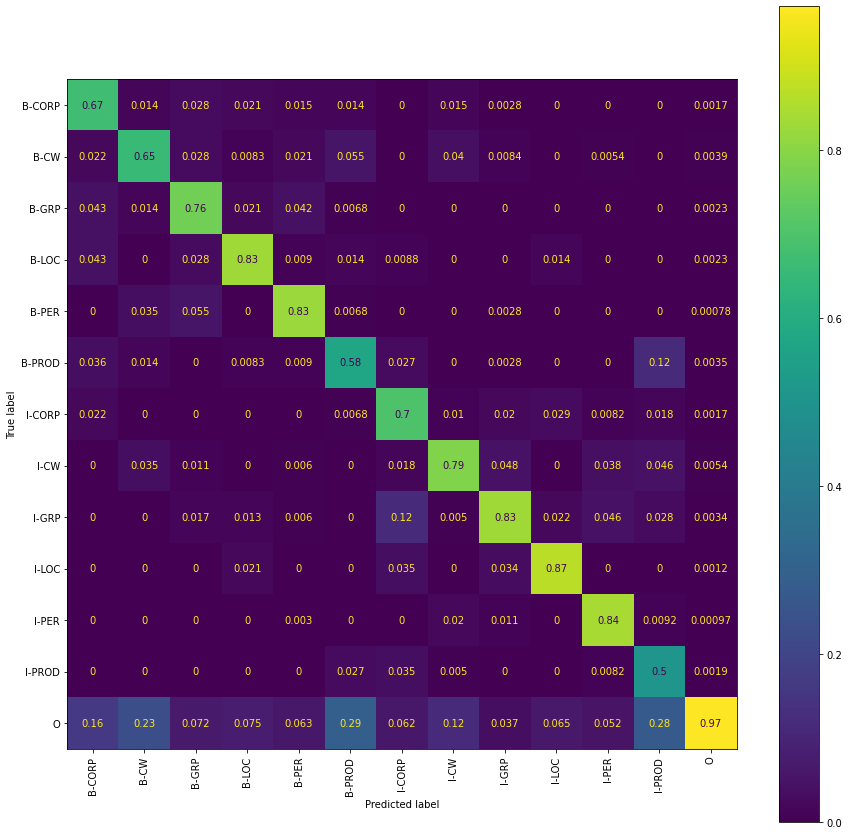

In [ ]:
gif, ax = plt.subplots(figsize=(15,15))
ConfusionMatrixDisplay.from_predictions(y_true=_val_gold_plain, y_pred=out_plain, 
                                        xticks_rotation='vertical', ax=ax, 
                                        normalize='pred',
                                        values_format=None)
plt.savefig("cf.svg")

## EXPORT OBJECTS

In [ ]:
OUTPUT_NAME ='NER_LSTM_POS_TAG'

In [ ]:
DIR_OUTPUT_LOCAL = os.path.join(DIR_OUTPUT, OUTPUT_NAME)
os.makedirs(DIR_OUTPUT_LOCAL)

In [ ]:
FILE_OUT_LABEL_MAP = os.path.join(DIR_OUTPUT_LOCAL, "label_map.pickle")
save_object(FILE_OUT_LABEL_MAP, LABEL_MAP)

In [ ]:
FILE_OUT_VOCAB_MAP = os.path.join(DIR_OUTPUT_LOCAL, "vocab_map.pickle")
save_object(FILE_OUT_VOCAB_MAP, VOCAB_MAP)

In [ ]:
FILE_OUT_WEIGHTS = os.path.join(DIR_OUTPUT_LOCAL, "export_" + weight_to_load)
ner_model_final.save_model(FILE_OUT_WEIGHTS)

In [ ]:
FILE_OUT_HPARAMS = os.path.join(DIR_OUTPUT_LOCAL, 'hparams.pickle')
save_object(FILE_OUT_HPARAMS, HPARAMS)

In [ ]:
FILE_OUT_POS_TAGGER = os.path.join(DIR_OUTPUT_LOCAL, 'pos_tagger.pickle')
save_object(FILE_OUT_POS_TAGGER, POS_TAGGER)

In [ ]:
FILE_OUT_GLOBAL_SETTING = os.path.join(DIR_OUTPUT_LOCAL, 'global_setting.pickle')
save_object(FILE_OUT_GLOBAL_SETTING, GLOBAL_SETTING)

# UNMOUNT

In [ ]:
drive.flush_and_unmount() 